In [2]:
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Pt. 1 Threshold-Based Segmentation

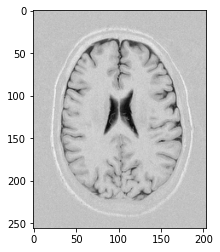

In [3]:
img = cv2.imread('materials/brain.png',0)
plt.imshow(img, 'gray')

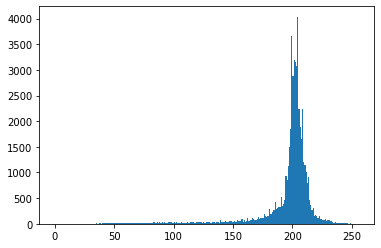

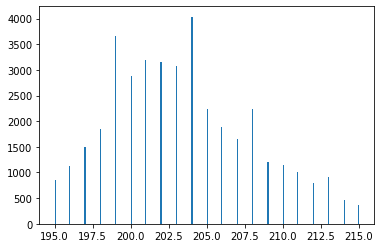

In [4]:
plt.hist(img.ravel(),256,[0,256]); plt.show()
plt.hist(img.ravel(),256,[195,215]); plt.show()

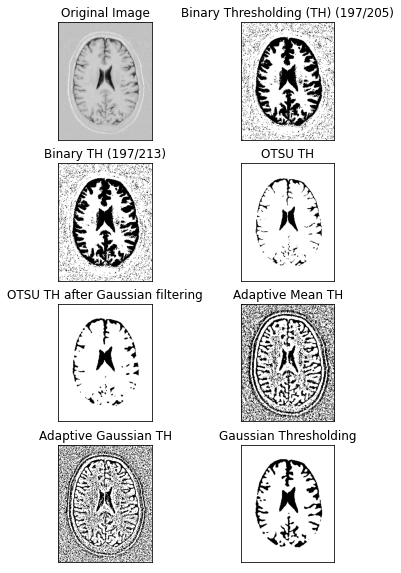

<Figure size 1440x720 with 0 Axes>

In [5]:
## TODO add image arithmetic for full points

plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=None)

ret,th1 = cv2.threshold(img,197,205,cv2.THRESH_BINARY)
ret,th2 = cv2.threshold(img,197,213,cv2.THRESH_BINARY)
ret,otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur = cv2.GaussianBlur(img,(5,5),0)
ret, gThr = cv2.threshold(blur,180, 220, cv2.THRESH_BINARY)
ret, otsuG = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
adm = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
adg = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)

images = [img, th1, th2, otsu, otsuG, adm, adg, gThr]
titles = [
    'Original Image', 'Binary Thresholding (TH) (197/205)',
    'Binary TH (197/213)','OTSU TH', 'OTSU TH after Gaussian filtering',
    'Adaptive Mean TH', 'Adaptive Gaussian TH', 'Gaussian Thresholding'
]
for i in range(len(images)):
    plt.subplot(4,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.figure(figsize=(20,10))
#l#t.tight_layout()
plt.show()

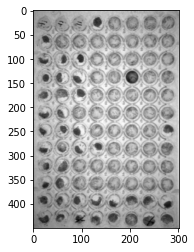

In [6]:
tray = cv2.imread('materials/tray.png',0)
plt.imshow(tray, 'gray')
t_hh, t_ww = tray.shape[:2]
t_max = max(t_hh, t_ww)

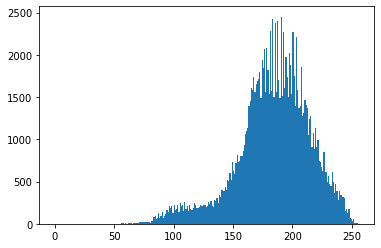

In [7]:
plt.hist(tray.ravel(),256,[0,256]); plt.show()

In [8]:
tray_1 = tray-blur
plt.hist(tray_1.ravel(),256,[0,256]); plt.show()

ret,th1 = cv2.threshold(tray_1,0,55,cv2.THRESH_BINARY)
plt.imshow(tray_1,'gray')

ValueError: operands could not be broadcast together with shapes (450,301) (256,204) 

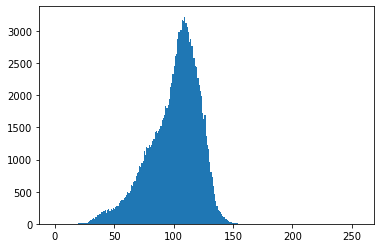

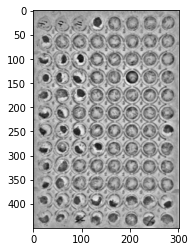

In [59]:
tray_1 = tray-blur+100
plt.hist(tray_1.ravel(),256,[0,256]); plt.show()


ret,th1 = cv2.threshold(tray_1,0,55,cv2.THRESH_BINARY)
plt.imshow(tray_1,'gray')

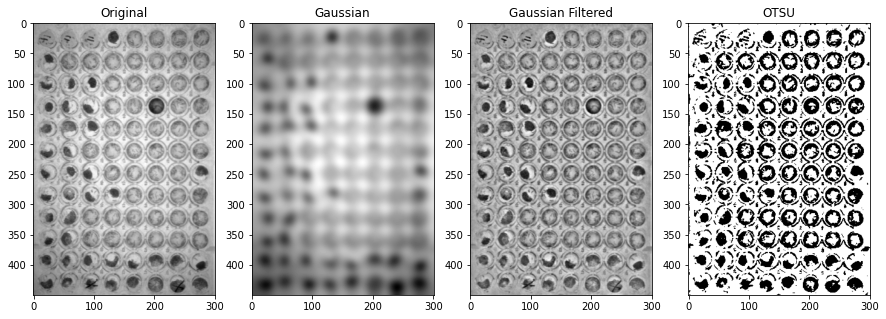

In [78]:
sigma = int(5 * t_max / 300)
blur = cv2.GaussianBlur(tray,(0,0),sigma,sigma)
tray_blur = tray-blur+100
ret, tThr = cv2.threshold(tray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(15, 8))
plt.subplot(141),plt.imshow(tray, 'gray'),plt.title('Original')
plt.subplot(142),plt.imshow(blur, 'gray'),plt.title('Gaussian')
plt.subplot(143),plt.imshow(tray-blur+100, 'gray'),plt.title('Gaussian Filtered')
plt.subplot(144),plt.imshow(tThr, 'gray'),plt.title('OTSU')
plt.show()

## Pt. 2 Labelling

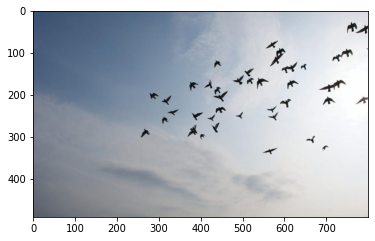

In [9]:
birds = cv2.imread('materials/birds.jpg', 0)
birds_cl = cv2.imread('materials/birds.jpg')
plt.imshow(cv2.cvtColor(birds_cl, cv2.COLOR_BGR2RGB))

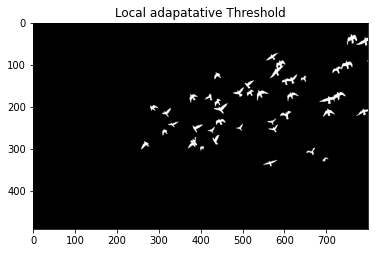

In [19]:

thresh = cv2.adaptiveThreshold(birds, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 80)
thresh = cv2.bitwise_not(thresh)
plt.title('Local adapatative Threshold')
plt.imshow(thresh, cmap="gray", vmin=0, vmax=255)

(<AxesSubplot:title={'center':'Erosion - large kernel'}>,
 Text(0.5, 1.0, 'Erosion - large kernel'))

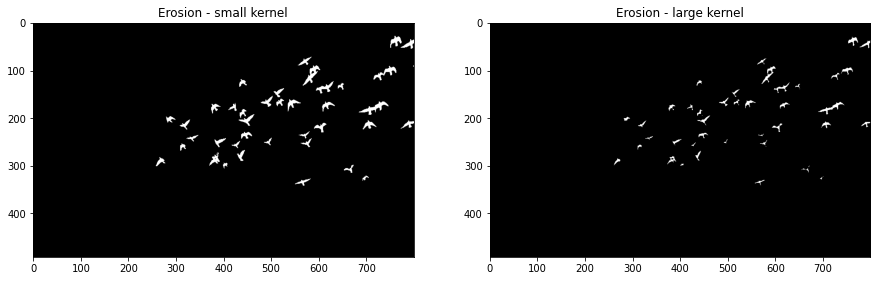

In [68]:
# Dilatation
# trying to separate the birds from each other
# not possible in some cases
kernel_small = np.ones((1,1), np.uint8)
kernel_large = np.ones((3,3), np.uint8)
img_eroded_small = cv2.erode(thresh, kernel_small, iterations=1)
img_eroded_large = cv2.erode(thresh, kernel_large, iterations=1)

plt.figure(figsize=(15, 8))
plt.subplot(121),plt.imshow(img_eroded_small, 'gray'),plt.title('Erosion - small kernel')
plt.subplot(122),plt.imshow(img_eroded_large, 'gray'),plt.title('Erosion - large kernel')

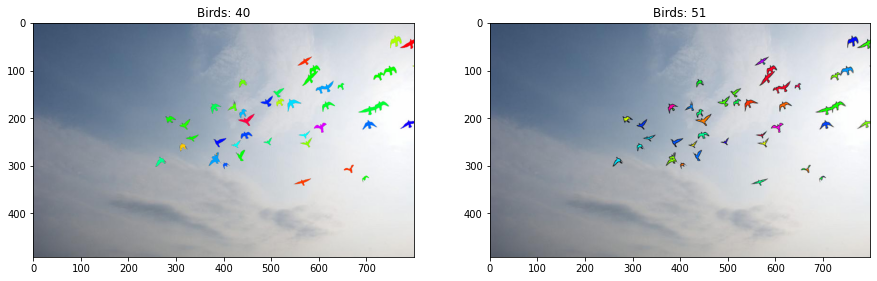

In [69]:
eroded_versions = [img_eroded_small, img_eroded_large]
labels = ['Erosion - small kernel', 'Erosion - larger kernel']
plt.figure(figsize=(15,8))
for _, img in enumerate(eroded_versions):
    ret, labels = cv2.connectedComponents(img)

    # create random labels without duplicates and assign them to the pixels
    random_labels = random.sample(range(1, 255), len(np.unique(labels)))
    label_hue = labels
    for i, x in enumerate(np.unique(labels)[1:]):
        label_hue[label_hue==x] = random_labels[i]
    # convert hue labels to int
    label_hue = np.uint8(label_hue)
    # create blank channel
    blank_ch = 255 * np.ones_like(label_hue)
    # merge into 3 channels
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # convert label image to bgr color space
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # convert image color space to same as labels so we can combine them
    birds_BGR = cv2.cvtColor(birds_cl, cv2.COLOR_BGR2RGB)
    labeled_img[label_hue == 0] = birds_BGR[(label_hue == 0)]

  
    
    plt.subplot(120+_+1),plt.imshow(labeled_img),plt.title('Birds: '+ str(ret-1))

In [34]:
'Objects counted: '+ str(ret-1)

'Objects counted: 51'

## Pt. 3 Stereo Imagery

In [12]:
from materials.disparity import getDisparityMap, plot

# Load left image
filename = 'materials/umbrellaL.png'
imgL = cv2.imread(filename, 0)
imgLGrey = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
imgLEdges = cv2.Canny(imgL,100,200)

# Load right image
filename = 'materials/umbrellaR.png'
imgR = cv2.imread(filename, 0)
imgRGrey = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
imgREdges = cv2.Canny(imgR,100,200)

# Get disparity map
disparity = getDisparityMap(imgL, imgR, 64, 5)
disparityGrey = getDisparityMap(imgLGrey, imgRGrey, 64, 5)
disparityEdges = getDisparityMap(imgLEdges, imgREdges, 64, 5)

# Normalise for display
disparityImg = np.interp(disparity, (disparity.min(), disparity.max()), (0.0, 1.0))
disparityImgGrey = np.interp(disparityGrey, (disparity.min(), disparity.max()), (0.0, 1.0))
disparityImgEdges = np.interp(disparityEdges, (disparity.min(), disparity.max()), (0.0, 1.0))

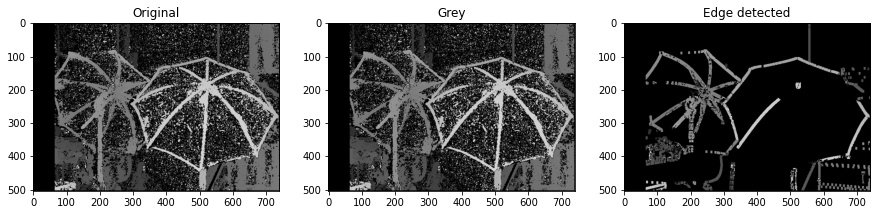

In [13]:
plt.figure(figsize=(15, 8))
plt.title('Disparity Images')
plt.subplot(131),plt.imshow(disparityImg, 'gray'),plt.title('Original')
plt.subplot(132),plt.imshow(disparityImgGrey, 'gray'),plt.title('Grey')
plt.subplot(133),plt.imshow(disparityImgEdges, 'gray'),plt.title('Edge detected')
plt.show()